In [1]:
from d2l import torch as d2l
import torch
from torch import nn

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use 'is_grad_enable' to determine whether the current mode is training mode or predict model
    if not torch.is_grad_enabled():
        #if it is predicton mode
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4) # 判断是否带梯度
        if len(X.shape) == 2:
            # 当是全连接层时候
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            #使用一个2D conv, 计算均值和方差在分别在每个channel(axis =1) (batch_num,channel_size,h,w)
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta

    return Y, moving_mean.data, moving_var.data

In [4]:
class BatchNorm(nn.Module):
    # num_features 是 全连接层的输出
    # num_dim 是卷积层的输出channel_num
    # 2 代表 全连接 ，4代表全连接层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        #初始化 scale parameter and shift parameter to o and 1 , respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                          self.moving_mean,self.moving_var,
                                                          eps=1e-5, momentum=0.9)
        return Y

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))



loss 0.248, train acc 0.909, test acc 0.880
36161.5 examples/sec on cuda:0


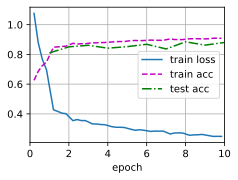

In [6]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [7]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.3349, 0.9071, 1.2981, 1.0617, 2.3213, 1.9261], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 0.8063,  0.1218, -0.6545, -1.4924,  0.4474, -2.0035], device='cuda:0',
        grad_fn=<ViewBackward>))

In [8]:
net2 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.251, train acc 0.908, test acc 0.835
56007.8 examples/sec on cuda:0


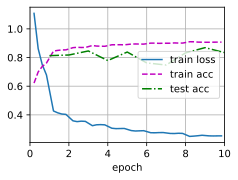

In [9]:
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr)